# Alzheimer's Disease Capstone Project
## Machine Learning and Predictive Modeling

The two primary questions that this analysis is trying to answer are:
1. Which biomarkers are correlated with a change in diagnosis to Alzheimer's Disease?
2. Which biomarkers might be able to predict a final diagnosis of Alzhiemer's Disease at an initial visit?

In [2]:
# load packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve

# load custom modules
from adnidatawrangling import wrangle_adni
import eda, ml

# set default plotting
plt.style.use('ggplot')

## 1. Which Biomarkers Are Correlated with a Progression Towards Alzheimer's Disease?
- Steps
    - Prepare data for analysis
        - Import/wrangle/clean
        - Extract the last exam and basline data
        - Calculate the change for each variables (deltas)
        - Extract the features and standardize the data
        - Separate the target and feature data

In [3]:
# import data, clean, and extract data
adni_comp, clin_data, scan_data = wrangle_adni()

# extract final exam data: only the last exam for each patient
final_exam = eda.get_final_exam(adni_comp)

# calculate the change in variables over the course of the study
eda.calc_deltas(final_exam)

# extract and scale the deltas data for ML analysis
feature_names, Xd, yd = ml.get_delta_scaled(final_exam)

In [4]:
# examine the structure of the data
print(feature_names.shape)
print(Xd.shape, yd.shape)

(11,)
(1134, 11) (1134,)


In [5]:
# split the data into test and train sets
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3, 
                                                    random_state=21, stratify=yd)

#### First Model k-Nearest Neighbors Classification
- The first model will try k-NN to predict the groups
- First, the best k will be chosen
    - Graphic approach
    - GridSearchCV approach

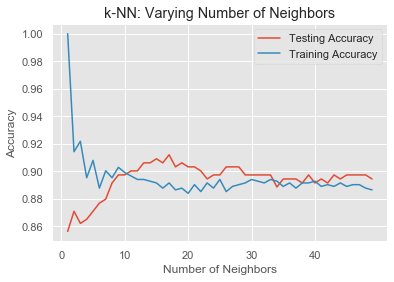

In [6]:
# plot the training and test accuracy with varying k values
ml.plot_best_k(Xd_train, Xd_test, yd_train, yd_test, kmax=50)

- Using this approach, the testing accuracy was highest at k=17. The test accuracy continues decrease a little after this, however, and it looks like both lines level out around the mid 30s. There could therefore be a few choices of k. Crossvalidation will be used to provide another measure of the best k. 

In [7]:
# find best k using GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 50)}

knn = KNeighborsClassifier()

knn_cv = GridSearchCV(knn, param_grid, cv=5)

knn_cv.fit(Xd_train, yd_train)

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(knn_cv.best_params_, knn_cv.best_score_)

{'n_neighbors': 39} 0.8890290037831021


- GridSearchCV returned 39 as the best k. Because the first method was a little ambiguous but still gave one option in the 30s, we will use 39 for k.

#### k-Nearest Neighbors Model in Action

In [8]:
# create the model
knn = KNeighborsClassifier(n_neighbors=39)

# fit the model
knn.fit(Xd_train, yd_train)

# generate predictions
y_pred = knn.predict(Xd_test)

In [9]:
# print the accuracy
print('Training Accuracy: {}'.format(knn.score(Xd_train, yd_train)))
print('Testing Accuracy: {}'.format(knn.score(Xd_test, yd_test)))

Training Accuracy: 0.8915510718789408
Testing Accuracy: 0.8973607038123167


In [10]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[280   7]
 [ 28  26]]
True Negatives: 280
False Positives: 7
False Negatives: 28
True Positives: 26


- The confusion matrix shows that this model is very good at predicting the true negatives. However, there were more false negatives than true positives, meaning the model does not have much power to detect Alzheimer's disease.
- Analyzing the precision and recall will provide more details.

In [11]:
k = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       287
           1       0.79      0.48      0.60        54

    accuracy                           0.90       341
   macro avg       0.85      0.73      0.77       341
weighted avg       0.89      0.90      0.89       341



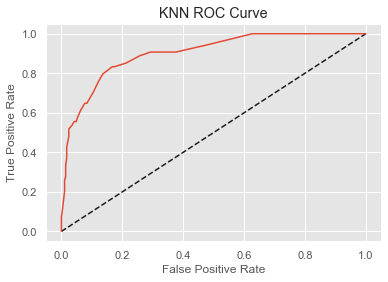

In [12]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = knn.predict_proba(Xd_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='KNN')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('KNN ROC Curve')

In [13]:
# compute the AUC
print(roc_auc_score(yd_test, y_pred_prob))

0.9012453219770293


- The ROC curve and auc score appear to be very good, however, this is an artifact of the imbalanced data, with the model doing very well with true negatives. The precision/recall curve illustrates this below.

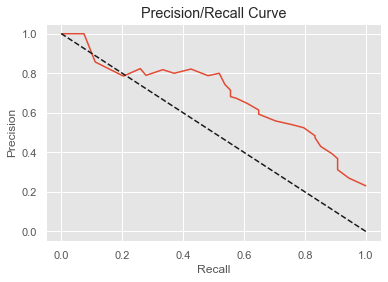

In [14]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision/recall curve illustrates that recall is not very good at high levels of precision. There is not much predictive value in the model when the precision or sensitivity is high. 

- While it is possible that the model could be improved by oversampling on the Alzheimer's group, different models will be tried that can account for the imbalanced data.

#### SVM Model

In [15]:
# extract and scale the deltas data for ML analysis using -1 and 1 as the classes for SVM
feature_names, Xd, yd = ml.get_delta_scaled(final_exam, neg_one=True)

# split the data into test and train sets
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3, 
                                                    random_state=21, stratify=yd)

num_features = len(feature_names)

In [16]:
# setup parameters to hyptertune
param_grid = {'C': [0.5, 0.75, 1.0, 1.25, 1.5], 
              'gamma': [(1/(num_features*Xd_train.var())), (1/num_features)]}

svm = SVC(class_weight='balanced', probability=True)

svm_cv = GridSearchCV(svm, param_grid, cv=5)

svm_cv.fit(Xd_train, yd_train)

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(svm_cv.best_params_, svm_cv.best_score_)

{'C': 0.75, 'gamma': 0.09071642694696025} 0.8373266078184111


In [17]:
# create the model
svm = SVC(C=0.75, gamma=1/(num_features*Xd_train.var()), class_weight='balanced',
         probability=True)

# fit the model
svm.fit(Xd_train, yd_train)

# generate predictions
y_pred = svm.predict(Xd_test)

In [18]:
# print the accuracy
print('The training accuracy was: {}'.format(svm.score(Xd_train, yd_train)))
print('The test accuracy was: {}'.format(svm.score(Xd_test, yd_test)))

The training accuracy was: 0.8701134930643127
The test accuracy was: 0.841642228739003


In [19]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[244  43]
 [ 11  43]]
True Negatives: 244
False Positives: 43
False Negatives: 11
True Positives: 43


- The SVM model did a better job with the true positives vs. false negatives than the knn model when using class weighting to account for the imbalanced data.
- The model did produce 43 false positives, but 50% of the patients the model flagged as positive did actually develop AD during the study.
- Of the patients that didn't develop AD, only 15% were incorrectly classified as false positive.
- The model did fail to predict 11 patients that did progress to AD, and it had a detection rate of around 80%

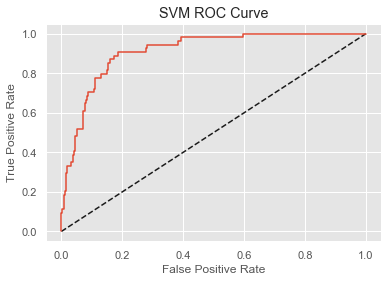

In [20]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = svm.predict_proba(Xd_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='SVM')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('SVM ROC Curve')

In [21]:
s = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

          -1       0.96      0.85      0.90       287
           1       0.50      0.80      0.61        54

    accuracy                           0.84       341
   macro avg       0.73      0.82      0.76       341
weighted avg       0.88      0.84      0.86       341



- The recall was much improved for the Alzheimer's class, but at the expense of precision. For this instance, this would be more desirable and a few false positives may be worth higher detection power when predicting AD.

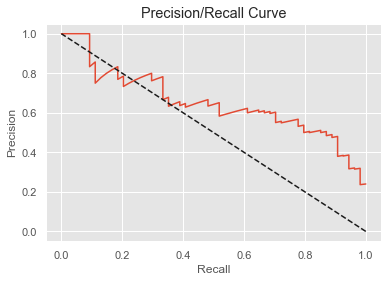

In [22]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision recall curve once again shows that the model suffers when recall is < 0.4. The model is better at predicting negative results than positive results. For this application, a model that can do well with the Alzheimer's or positive class is desired.

#### Random Forest Classifier

In [23]:
# extract and scale the deltas data for ML analysis using 0 and 1 as the classes for Random Forest
feature_names, Xd, yd = ml.get_delta_scaled(final_exam)

# split the data into test and train sets
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.3, 
                                                    random_state=21, stratify=yd)

In [24]:
# tune hyperparameters n_estimators and max_features
trees = [131, 141, 151, 161, 171]

max_f = [1, 10, 'log2', 'sqrt']

param_grid = {'n_estimators': trees, 'max_features': max_f}

r_forest = RandomForestClassifier(class_weight='balanced', random_state=42)

r_forest_cv = GridSearchCV(r_forest, param_grid, cv=5)

r_forest_cv.fit(Xd_train, yd_train)

n_est = r_forest_cv.best_params_['n_estimators']
n_feat = r_forest_cv.best_params_['max_features']

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(r_forest_cv.best_params_, r_forest_cv.best_score_)

{'max_features': 1, 'n_estimators': 151} 0.8965952080706179


In [25]:
# build the model
rfc = RandomForestClassifier(n_estimators=n_est, max_features=n_feat, 
                             class_weight='balanced', random_state=42)

# fit the model
rfc.fit(Xd_train, yd_train)

# generate predictions
y_pred = rfc.predict(Xd_test)

In [26]:
# print the accuracy
print('The training accuracy was: {}'.format(rfc.score(Xd_train, yd_train)))
print('The test accuracy was: {}'.format(rfc.score(Xd_test, yd_test)))

The training accuracy was: 1.0
The test accuracy was: 0.8856304985337243


In [27]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[275  12]
 [ 27  27]]
True Negatives: 275
False Positives: 12
False Negatives: 27
True Positives: 27


- Cross validation picked 1 for the max tree length, using only stumps for each tree.
- The random forest model did very well with the negative class, but once again failed to perform for the positive class (Alzheimer's disease). 
- Patients that didn't progress to Alzheimer's were predicted pretty accurately, but only 50% of the patients that progressed to Alzheimer's were identified by the model.
- If a doctor is taking a very cautious approach to warning patients, then this could be a good model. Most of the patients that would not be warned about being at risk would not develop AD (248/302, about 82%).
- This model did have a better positive detection rate vs. SVM, with nearly 70% of patients flagged as postive actually developing AD.

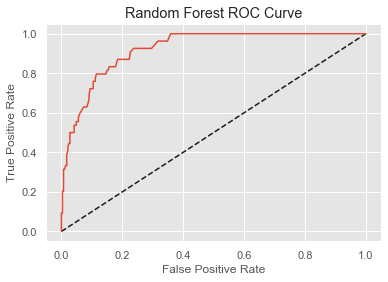

In [28]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = rfc.predict_proba(Xd_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='RFC')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Random Forest ROC Curve')

In [29]:
r = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       287
           1       0.69      0.50      0.58        54

    accuracy                           0.89       341
   macro avg       0.80      0.73      0.76       341
weighted avg       0.88      0.89      0.88       341



- Both the precision and recall were lower for the positive (AD) class.

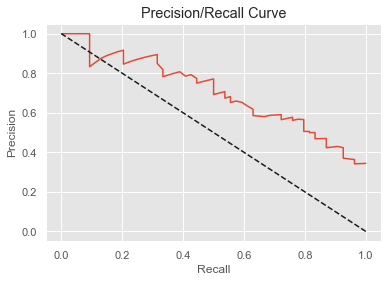

In [30]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

#### AdaBoost for Boosting

In [31]:
# tune hyperparameter number of estimators
est = [41, 51, 61, 71, 81]

param_grid = {'n_estimators': est}

boost = AdaBoostClassifier(random_state=42)

boost_cv = GridSearchCV(boost, param_grid, cv=5)

boost_cv.fit(Xd_train, yd_train)

n_est = boost_cv.best_params_['n_estimators']

# print the best value(s) for each hyperparameter and the mean of the best validation score
print(boost_cv.best_params_, boost_cv.best_score_)

{'n_estimators': 51} 0.8751576292559899


In [32]:
# run the model with the best n_estimators
model = AdaBoostClassifier(n_estimators=n_est, random_state=0)
model.fit(Xd_train, yd_train)
y_pred = model.predict(Xd_test)
print('Training accuracy: {}'.format(model.score(Xd_train, yd_train)))
print('Testing accuracy: {}'.format(model.score(Xd_test, yd_test)))

Training accuracy: 0.9344262295081968
Testing accuracy: 0.8826979472140762


In [33]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[265  22]
 [ 18  36]]
True Negatives: 265
False Positives: 22
False Negatives: 18
True Positives: 36


- Boosting improved on the random forest model for prediction power, with 2/3 of the 54 patients with AD being correctly identified.
- The model still failed to detect progression to AD in 18 patients, however.
- This model might be preferred by cautious doctors that would rather have false negatives than false positives.

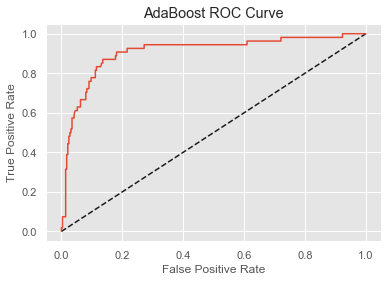

In [34]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = model.predict_proba(Xd_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='Boost')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('AdaBoost ROC Curve')

In [35]:
b = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       287
           1       0.62      0.67      0.64        54

    accuracy                           0.88       341
   macro avg       0.78      0.80      0.79       341
weighted avg       0.89      0.88      0.88       341



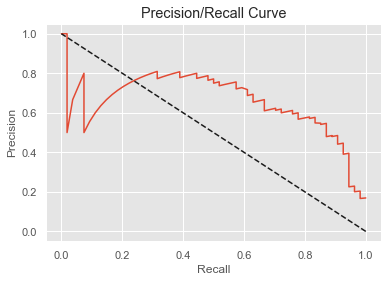

In [36]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision recall curve again shows the tradeoff in prediction power with high precision.
- Overall, the model's performance is not satisfactory for prediction a progression to AD.

#### Logistic Regression

In [37]:
# build the model
logreg = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42)

# fit the model
logreg.fit(Xd_train, yd_train)

# generate predictions
y_pred = logreg.predict(Xd_test)

In [38]:
# print the accuracy
print('The training accuracy was: {}'.format(logreg.score(Xd_train, yd_train)))
print('The test accuracy was: {}'.format(logreg.score(Xd_test, yd_test)))

The training accuracy was: 0.8562421185372006
The test accuracy was: 0.8533724340175953


In [39]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[244  43]
 [  7  47]]
True Negatives: 244
False Positives: 43
False Negatives: 7
True Positives: 47


- The logistic model performed better at identifying patients that progressed to AD at the expense of adding more false positives.
- This model would be preferred by physicians that would rather catch every patient at a high risk of AD while not as concerned with false positives.
- While there were 43 false positives, 244/287 (85%) of the patients that didn't progress to AD were correctly identified by this model.
- The detection rate was similar at 47/54 or about 87%.
- This the best model so far for predicting progression to AD, improving on the SVM model that was leading to this point.

In [40]:
l = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       287
           1       0.52      0.87      0.65        54

    accuracy                           0.85       341
   macro avg       0.75      0.86      0.78       341
weighted avg       0.90      0.85      0.87       341



- The recall (detection rate) was much higher for the positive class, and the negative detection rate of 85% was also good. Precision was not great for the Alzheimer's class, with only about half of those identified as at risk for AD were diagnosed with the disease by the end of the study.
- Still, of these patients, some may have been diagnosed after the study, and this may be an acceptable rate when the recall rates are considered.

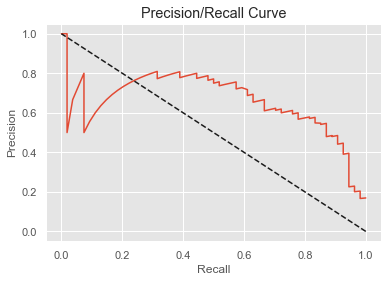

In [41]:
# plot the precision/recall curve
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- Once again, the precision was low, but this is partly due to the imbalanced data. This model has performed the best so far. The ROC-AUC metrics support this.

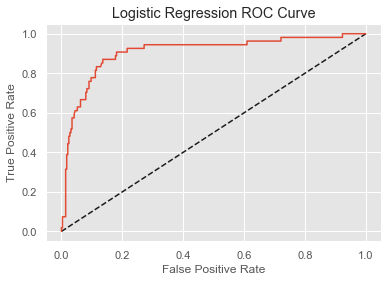

In [42]:
# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='Logistic Regression')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Logistic Regression ROC Curve')

In [43]:
# compute the AUC
print(roc_auc_score(yd_test, y_pred_prob))

0.9068912117692605


#### Naive Bayes

In [44]:
# get rid of negative values in the feature data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(Xd_train)

# instantize the model
model = MultinomialNB()

# fit the model
model.fit(X_scaled, yd_train)

# generate predictions
y_pred = model.predict(Xd_test)

In [45]:
# print the accuracy
print('The training accuracy was: {}'.format(model.score(X_scaled, yd_train)))
print('The test accuracy was: {}'.format(model.score(Xd_test, yd_test)))

The training accuracy was: 0.8411097099621689
The test accuracy was: 0.8475073313782991


In [46]:
# print the confusion matrix
print(confusion_matrix(yd_test, y_pred))
tn, fp, fn, tp = confusion_matrix(yd_test, y_pred).ravel()
print('True Negatives: {}'.format(tn))
print('False Positives: {}'.format(fp))
print('False Negatives: {}'.format(fn))
print('True Positives: {}'.format(tp))

[[254  33]
 [ 19  35]]
True Negatives: 254
False Positives: 33
False Negatives: 19
True Positives: 35


- Naive Bayes took a balanced approach to this problem. The detection rate was better than some models with about 65% detection rate. 
- Like some of the other models, this model performed better on the negative class, with 93% of the negative classifications being correct.
- This model underperformed with respect to detecting AD, but could be useful if a doctor is wanting to avoid false positives.

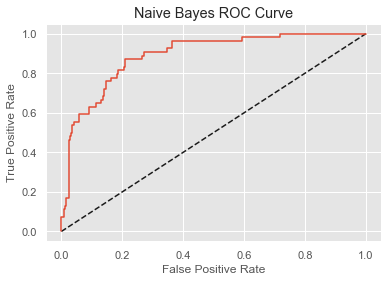

In [47]:
# returns an array with two columns: each column contains probabilities for the target values
# we are selecting the probability of being a 1
y_pred_prob = model.predict_proba(Xd_test)[:,1]

# unpack into false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(yd_test, y_pred_prob)

_ = plt.plot([0,1], [0,1], 'k--')
_ = plt.plot(fpr, tpr, label='NB')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('Naive Bayes ROC Curve')

In [48]:
n = classification_report(yd_test, y_pred, output_dict=True)
print(classification_report(yd_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       287
           1       0.51      0.65      0.57        54

    accuracy                           0.85       341
   macro avg       0.72      0.77      0.74       341
weighted avg       0.86      0.85      0.85       341



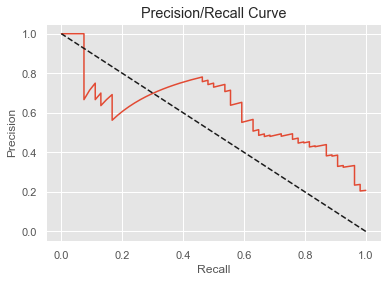

In [49]:
# plot the precision/recall curve
y_pred_prob = model.predict_proba(Xd_test)[:,1]
precision, recall, thresholds = precision_recall_curve(yd_test, y_pred_prob)

_ = plt.plot(recall, precision)
_ = plt.plot([1,0], [0,1], 'k--')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision/Recall Curve')

- The precision recall plot illustrates the lack of prediction power when precision is high.

## 1. Question One Summary: Detecting a Progression to Alzheimer's by Analyzing Changes in Biomarkers
- The Logistic Regression model performed the best at detecting AD, followed by AdaBoost and SVM.
    - These were the best models for detection power, producing the least amount of false negatives.
    - Each of these three models had higher false positive rates than the other models, but my opinion is that a certain number of false positives is acceptable for trying to start early brain training excercises to prevent AD.
    - The overall false positive rates were still low, considering the total number of patients that did not develop AD, and model performance was good for the Non AD class for all models (red bars).
- Several models performed well on the negative class, at the expense of losing detection power for Alzheimer's Disease.

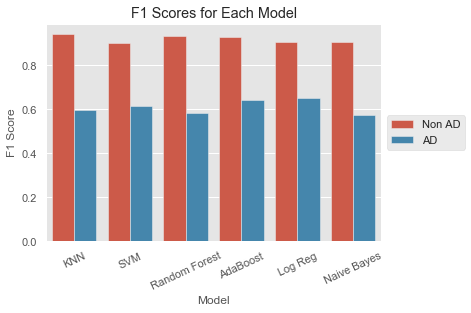

In [53]:
# plot the f1-scores for each model
ml.plot_f1_scores(k, s, r, b, l, n)

In [54]:
# old code for reference

In [55]:
# map the diagnosis group and assign to dx_group
nc_idx = final_exam[final_exam.DX == final_exam.DX_bl2].index
cn_mci_idx = final_exam[(final_exam.DX == 'MCI') & (final_exam.DX_bl2 == 'CN')].index
mci_ad_idx = final_exam[(final_exam.DX == 'AD') & (final_exam.DX_bl2 == 'MCI')].index
cn_ad_idx = final_exam[(final_exam.DX == 'AD') & (final_exam.DX_bl2 == 'CN')].index

labels = pd.concat([pd.DataFrame({'dx_group': 'No Change'}, index=nc_idx),
                    pd.DataFrame({'dx_group': 'CN to MCI'}, index=cn_mci_idx),
                    pd.DataFrame({'dx_group': 'MCI to AD'}, index=mci_ad_idx),
                    pd.DataFrame({'dx_group': 'CN to AD'}, index=cn_ad_idx)
                   ]).sort_index()

In [56]:
# add to the dataframe and ensure every row has a label
deltas_df = final_exam.loc[labels.index]
deltas_df.loc[:,'dx_group'] = labels.dx_group 

In [57]:
type(deltas_df)

pandas.core.frame.DataFrame

In [58]:
pd.get_dummies(deltas_df, drop_first=True, columns=['PTGENDER'])

,DX,DX_bl,EXAMDATE,EXAMDATE_bl,PTEDUCAT,Month,AGE,CDRSB,CDRSB_bl,ADAS11,...,ADAS13_delta,MMSE_delta,RAVLT_delta,Hippocampus_delta,Ventricles_delta,WholeBrain_delta,Entorhinal_delta,MidTemp_delta,dx_group,PTGENDER_Male
3,AD,AD,2007-09-12,2005-09-12,18,24,81.3,8,4.5,25.67,...,6.67,-1,1,-180,12821,-41270,-616,-2024,No Change,1
4,MCI,LMCI,2008-11-18,2005-11-08,10,36,67.5,1,1,18,...,3.67,-2,7,-656,5649,-69630,-931,-681,No Change,1
5,CN,CN,2008-09-10,2005-09-07,16,36,73.7,1,0,6.67,...,-3,1,5,-680,7594,-36140,-828,-1216,No Change,1
6,MCI,LMCI,2008-12-08,2005-11-29,13,36,80.4,2,0.5,17.67,...,1,-3,-4,-439,6723,-3107,32,-446,No Change,0
7,AD,AD,2006-04-13,2005-10-06,10,6,75.4,6,6,32.67,...,5.34,3,2,41,1106,-16851,244,-915,No Change,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5269,CN,SMC,2015-09-01,2013-08-20,16,24,64.9,0,0,3,...,-6,-2,11,-152,1541,-11960,-99,-81,No Change,1
5277,CN,SMC,2015-08-31,2013-08-28,15,24,71.8,0.5,0.5,7,...,4,-4,-19,-822,4454,-26322,-343,-358,No Change,0
5289,CN,SMC,2014-05-19,2013-11-11,16,6,59.7,0,0,4,...,-6,1,-16,-72,2035,-2530,-92,7,No Change,0
5290,CN,SMC,2015-10-01,2013-09-24,12,24,67,0,0,6,...,1,1,-1,-117,2111,-21310,-4,159,No Change,0


In [59]:
# extract the features for change in diagnosis
X_delta_male = deltas_df[deltas_df.PTGENDER == 'Male'].reindex(columns=['CDRSB_delta', 'ADAS11_delta', 
                                                                        'ADAS13_delta', 'MMSE_delta',
                                                                        'RAVLT_delta', 'Hippocampus_delta',
                                                                        'Ventricles_delta', 'WholeBrain_delta',
                                                                        'Entorhinal_delta', 'MidTemp_delta'])
X_delta_female = deltas_df[deltas_df.PTGENDER == 'Female'].reindex(columns=['CDRSB_delta', 'ADAS11_delta', 
                                                                        'ADAS13_delta', 'MMSE_delta',
                                                                        'RAVLT_delta', 'Hippocampus_delta',
                                                                        'Ventricles_delta', 'WholeBrain_delta',
                                                                        'Entorhinal_delta', 'MidTemp_delta'])

In [60]:
male_scaler = StandardScaler()
female_scaler = StandardScaler()
Xd_male = male_scaler.fit_transform(X_delta_male)
Xd_female = female_scaler.fit_transform(X_delta_female)

In [61]:
# extract the labels
yd_male = np.array(deltas_df[deltas_df.PTGENDER == 'Male'].dx_group)
yd_female = np.array(deltas_df[deltas_df.PTGENDER == 'Female'].dx_group)

In [62]:
print(X_delta_male.shape, yd_male.shape)
print(X_delta_female.shape, yd_female.shape)

(624, 10) (624,)
(510, 10) (510,)
